In [49]:
!wget https://raw.githubusercontent.com/YongWei12/InformationRetrival/master/classification/labelled_data.csv
!wget https://raw.githubusercontent.com/YongWei12/InformationRetrival/master/classification/data.csv
!pip install spacytextblob

--2021-03-29 16:04:11--  https://raw.githubusercontent.com/YongWei12/InformationRetrival/master/classification/labelled_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581621 (568K) [text/plain]
Saving to: ‘labelled_data.csv.1’

labelled_data.csv.1 100%[===================>] 567.99K  --.-KB/s    in 0.05s   

2021-03-29 16:04:11 (11.1 MB/s) - ‘labelled_data.csv.1’ saved [581621/581621]

--2021-03-29 16:04:11--  https://raw.githubusercontent.com/YongWei12/InformationRetrival/master/classification/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiti

In [50]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = stopwords.words('english')

def cleaner(tweet):
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    #remove emoji
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return  tweet


data = pd.read_csv("labelled_data.csv", error_bad_lines=False)[["tweet", "polarity"]]
data['tweet'] = data['tweet'].apply(lambda x:x.lower())
data['tweet'] = data['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['tweet'] = data['tweet'].apply(cleaner)
data.head()
print(data.shape)
print(data.polarity.value_counts())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(1000, 2)
neutral     500
positive    250
negative    250
Name: polarity, dtype: int64


In [51]:

import numpy as np
import sklearn
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Approach 1: using spacy
# nlp = spacy.load('en_core_web_sm')
# spacy_text_blob = SpacyTextBlob()
# nlp.add_pipe(spacy_text_blob)
# def calculate(s):
#     x = nlp(s['tweet'])
#     return x._.sentiment.polarity, x._.sentiment.subjectivity
# start = time.time()
# data[['polarity_score', 'subjectivity_score']] = data.apply(calculate, axis = 1, result_type = 'expand')
# end = time.time()
# time_taken = end - start
# Results
# precision (weighted): 58.46%
# recall (weighted): 56.58%
# f1 (weighted): 55.52%
# time taken: 13.21sec
# time to process each tweet: 0.01402sec

# Approach 2: using textblob
from textblob import TextBlob
start = time.time()
def calculate(s):
    x = TextBlob(s['tweet'])
    return x.polarity, x.subjectivity
data[['polarity_score', 'subjectivity_score']] = data.apply(calculate, axis = 1, result_type = 'expand')
end = time.time()
time_taken = end - start
# Results
# precision (weighted): 58.46%
# recall (weighted): 56.58%
# f1 (weighted): 55.52%
# time taken: 0.59sec
# time to process each tweet: 0.00062sec

In [52]:
# If < subjectivity_threshold, mark as neutral
# If >= subjectivity_threshold, then we consider if it is positive or negative
subjectivity_threshold = 0.45

conditions = [
    (data['subjectivity_score'] < subjectivity_threshold),
    (data['subjectivity_score'] >= subjectivity_threshold) & (data['polarity_score'] > 0),
    (data['subjectivity_score'] >= subjectivity_threshold) & (data['polarity_score'] < 0),
    (data['subjectivity_score'] >= subjectivity_threshold) & (data['polarity_score'] == 0)
    ]

choices = ['neutral', 'positive', 'negative', 'neutral']

data['predicted_polarity'] = np.select(conditions, choices)

#data.drop(columns = ["polarity_score", "subjectivity_score"], inplace = True)

# Provide evaluation metrics such as precision, recall, and F-measure and discuss results
# Discuss performance metrics, e.g., records classified per second, and scalability of the system

# because we have "neutral", "positive" and "negative", so we cannot use "binary" for average
weighted_precision = sklearn.metrics.precision_score(y_true = data["polarity"], y_pred = data["predicted_polarity"], average = "weighted")
weighted_recall = sklearn.metrics.recall_score(y_true = data["polarity"], y_pred = data["predicted_polarity"], average = "weighted")
weighted_f1 = sklearn.metrics.f1_score(y_true = data["polarity"], y_pred = data["predicted_polarity"], average = "weighted")

print("precision (weighted): {}%".format(round(weighted_precision * 100, 2)))
print("recall (weighted): {}%".format(round(weighted_recall * 100, 2)))
print("f1 (weighted): {}%".format(round(weighted_f1 * 100, 2)))
print("time taken: {}sec".format(round(time_taken, 2)))
print("time to process each tweet: {}sec".format(round(time_taken / data.shape[0], 5)))



precision (weighted): 57.81%
recall (weighted): 56.9%
f1 (weighted): 55.62%
time taken: 0.58sec
time to process each tweet: 0.00058sec


In [53]:
data["actual_negative"] = data["polarity"] == "negative"
data["pred_negative"] = data["predicted_polarity"] == "negative"

negative_precision = sklearn.metrics.precision_score(y_true = data["actual_negative"], y_pred = data["pred_negative"], average = "binary")
negative_recall = sklearn.metrics.recall_score(y_true = data["actual_negative"], y_pred = data["pred_negative"], average = "binary")
negative_f1 = sklearn.metrics.f1_score(y_true = data["actual_negative"], y_pred = data["pred_negative"], average = "binary")

data["actual_positive"] = data["polarity"] == "positive"
data["pred_positive"] = data["predicted_polarity"] == "positive"

positive_precision = sklearn.metrics.precision_score(y_true = data["actual_positive"], y_pred = data["pred_positive"], average = "binary")
positive_recall = sklearn.metrics.recall_score(y_true = data["actual_positive"], y_pred = data["pred_positive"], average = "binary")
positive_f1 = sklearn.metrics.f1_score(y_true = data["actual_positive"], y_pred = data["pred_positive"], average = "binary")

data["actual_neutral"] = data["polarity"] == "neutral"
data["pred_neutral"] = data["predicted_polarity"] == "neutral"

neutral_precision = sklearn.metrics.precision_score(y_true = data["actual_neutral"], y_pred = data["pred_neutral"], average = "binary")
neutral_recall = sklearn.metrics.recall_score(y_true = data["actual_neutral"], y_pred = data["pred_neutral"], average = "binary")
neutral_f1 = sklearn.metrics.f1_score(y_true = data["actual_neutral"], y_pred = data["pred_neutral"], average = "binary")

print("precision (positive): {}%".format(round(positive_precision * 100, 2)))
print("recall (positive): {}%".format(round(positive_recall * 100, 2)))
print("f1 (positive): {}%".format(round(positive_f1 * 100, 2)))

print("precision (neutral): {}%".format(round(neutral_precision * 100, 2)))
print("recall (neutral): {}%".format(round(neutral_recall * 100, 2)))
print("f1 (neutral): {}%".format(round(neutral_f1 * 100, 2)))

print("precision (negative): {}%".format(round(negative_precision * 100, 2)))
print("recall (negative): {}%".format(round(negative_recall * 100, 2)))
print("f1 (negative): {}%".format(round(negative_f1 * 100, 2)))

precision (positive): 45.62%
recall (positive): 60.4%
f1 (positive): 51.98%
precision (neutral): 63.16%
recall (neutral): 69.6%
f1 (neutral): 66.22%
precision (negative): 59.32%
recall (negative): 28.0%
f1 (negative): 38.04%


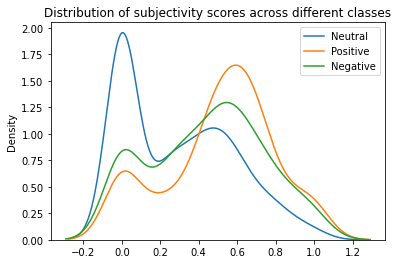

In [54]:
# graph = sns.displot(data[data['polarity'] == 'neutral']["subjectivity_score"].tolist())
# graph.fig.suptitle("Neutral tweet's subjectivity score")

# graph = sns.displot(data[data['polarity'] == 'positive']["subjectivity_score"].tolist())
# graph.fig.suptitle("Positive tweet's subjectivity score")

# graph = sns.displot(data[data['polarity'] == 'negative']["subjectivity_score"].tolist())
# graph.fig.suptitle("Negative tweet's subjectivity score")

sns.kdeplot(data[data['polarity'] == 'neutral']["subjectivity_score"].tolist(), label = "Neutral")
sns.kdeplot(data[data['polarity'] == 'positive']["subjectivity_score"].tolist(), label = "Positive")
sns.kdeplot(data[data['polarity'] == 'negative']["subjectivity_score"].tolist(), label = "Negative")

plt.legend()
plt.title("Distribution of subjectivity scores across different classes")
plt.show()

In [55]:
# Textblob is able to achieve the same accuracy metrics as spacy
# but at 16.94x of the speed

In [56]:
data = pd.read_csv("data.csv", error_bad_lines=False)

data['tweet'] = data['tweet'].apply(lambda x:x.lower())
data['tweet'] = data['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['tweet'] = data['tweet'].apply(cleaner)

start = time.time()
data[['polarity_score', 'subjectivity_score']] = data.apply(calculate, axis = 1, result_type = 'expand')
end = time.time()
time_taken = end - start

subjectivity_threshold = 0.45

conditions = [
    (data['subjectivity_score'] < subjectivity_threshold),
    (data['subjectivity_score'] >= subjectivity_threshold) & (data['polarity_score'] > 0),
    (data['subjectivity_score'] >= subjectivity_threshold) & (data['polarity_score'] < 0),
    (data['subjectivity_score'] >= subjectivity_threshold) & (data['polarity_score'] == 0)
    ]

choices = ['neutral', 'positive', 'negative', 'neutral']

data['polarity'] = np.select(conditions, choices)

print("time taken: {}sec".format(round(time_taken, 2)))
print("time to process each tweet: {}sec".format(round(time_taken / data.shape[0], 5)))

time taken: 8.68sec
time to process each tweet: 0.0006sec


In [57]:
data.to_csv("predictions.csv", index = False)

In [58]:
# Approach 3
data = pd.read_csv("labelled_data.csv", error_bad_lines=False)[["tweet", "polarity"]]

data['tweet'] = data['tweet'].apply(lambda x:x.lower())
data['tweet'] = data['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['tweet'] = data['tweet'].apply(cleaner)

#!pip install transformers
from transformers import pipeline
import time
from textblob import TextBlob
import numpy as np
import sklearn

# Initialise Sentiment Analysis Pipeline(Bert large finetuned on SQuAD 1.0)
nlp = pipeline('sentiment-analysis')

# First we decide if neutral
def calculate(s):
    x = TextBlob(s['tweet'])
    return x.polarity, x.subjectivity
start = time.time()
data[['polarity_score', 'subjectivity_score']] = data.apply(calculate, axis = 1, result_type = 'expand')
end = time.time()
time_taken = end - start

subjectivity_threshold = 0.45
conditions = [
    (data['subjectivity_score'] < subjectivity_threshold),
    ]
choices = ['neutral']
data['predicted_polarity'] = np.select(conditions, choices, default = None)

start = time.time()
sentiment = pd.DataFrame(nlp(data[data['subjectivity_score'] >= subjectivity_threshold]["tweet"].tolist()))
end = time.time()
time_taken = time_taken + end - start
sentiment.index = data.loc[data["subjectivity_score"] >= subjectivity_threshold, "predicted_polarity"].index
data.loc[data["subjectivity_score"] >= subjectivity_threshold, "predicted_polarity"] = sentiment['label']
data.loc[:, "predicted_polarity"] = data.loc[:, "predicted_polarity"].str.lower()

weighted_precision = sklearn.metrics.precision_score(y_true = data["polarity"], y_pred = data["predicted_polarity"], average = "weighted")
weighted_recall = sklearn.metrics.recall_score(y_true = data["polarity"], y_pred = data["predicted_polarity"], average = "weighted")
weighted_f1 = sklearn.metrics.f1_score(y_true = data["polarity"], y_pred = data["predicted_polarity"], average = "weighted")

print("precision (weighted): {}%".format(round(weighted_precision * 100, 2)))
print("recall (weighted): {}%".format(round(weighted_recall * 100, 2)))
print("f1 (weighted): {}%".format(round(weighted_f1 * 100, 2)))
print("time taken: {}sec".format(round(time_taken, 2)))
print("time to process each tweet: {}sec".format(round(time_taken / data.shape[0], 5)))

precision (weighted): 56.87%
recall (weighted): 55.6%
f1 (weighted): 55.54%
time taken: 75.11sec
time to process each tweet: 0.07511sec


In [59]:
data["actual_negative"] = data["polarity"] == "negative"
data["pred_negative"] = data["predicted_polarity"] == "negative"

negative_precision = sklearn.metrics.precision_score(y_true = data["actual_negative"], y_pred = data["pred_negative"], average = "binary")
negative_recall = sklearn.metrics.recall_score(y_true = data["actual_negative"], y_pred = data["pred_negative"], average = "binary")
negative_f1 = sklearn.metrics.f1_score(y_true = data["actual_negative"], y_pred = data["pred_negative"], average = "binary")

data["actual_positive"] = data["polarity"] == "positive"
data["pred_positive"] = data["predicted_polarity"] == "positive"

positive_precision = sklearn.metrics.precision_score(y_true = data["actual_positive"], y_pred = data["pred_positive"], average = "binary")
positive_recall = sklearn.metrics.recall_score(y_true = data["actual_positive"], y_pred = data["pred_positive"], average = "binary")
positive_f1 = sklearn.metrics.f1_score(y_true = data["actual_positive"], y_pred = data["pred_positive"], average = "binary")

data["actual_neutral"] = data["polarity"] == "neutral"
data["pred_neutral"] = data["predicted_polarity"] == "neutral"

neutral_precision = sklearn.metrics.precision_score(y_true = data["actual_neutral"], y_pred = data["pred_neutral"], average = "binary")
neutral_recall = sklearn.metrics.recall_score(y_true = data["actual_neutral"], y_pred = data["pred_neutral"], average = "binary")
neutral_f1 = sklearn.metrics.f1_score(y_true = data["actual_neutral"], y_pred = data["pred_neutral"], average = "binary")

print("precision (positive): {}%".format(round(positive_precision * 100, 2)))
print("recall (positive): {}%".format(round(positive_recall * 100, 2)))
print("f1 (positive): {}%".format(round(positive_f1 * 100, 2)))

print("precision (neutral): {}%".format(round(neutral_precision * 100, 2)))
print("recall (neutral): {}%".format(round(neutral_recall * 100, 2)))
print("f1 (neutral): {}%".format(round(neutral_f1 * 100, 2)))

print("precision (negative): {}%".format(round(negative_precision * 100, 2)))
print("recall (negative): {}%".format(round(negative_recall * 100, 2)))
print("f1 (negative): {}%".format(round(negative_f1 * 100, 2)))

precision (positive): 61.59%
recall (positive): 40.4%
f1 (positive): 48.79%
precision (neutral): 63.38%
recall (neutral): 66.8%
f1 (neutral): 65.04%
precision (negative): 39.16%
recall (negative): 48.4%
f1 (negative): 43.29%


In [60]:
#Approach 4 (Question 5 Ensemble Classification: Max Voting with 3 base model: Gradient Boosting Classifier, Decision Tree Classifier, K-Nearest Neighbour
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [61]:
# converting polarity to number, Neutral = 0 , Positive = 1 , Negative = 2
data.loc[data['polarity']=='neutral','polarity']= 0
data.loc[data['polarity']=='positive','polarity']= 1
data.loc[data['polarity']=='negative','polarity']= 2
data['polarity']= data['polarity'].astype(str).astype(int)

In [62]:
#splitting data set to train and test set 80%:20%
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['polarity'], test_size=0.2, random_state=42)

In [63]:
#To represent text data numerically so that we can run Gradient Boosting Classifier, Decision Tree Classifier, K-Nearest Neighbour
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(data.tweet)
XTrainVec = vectorizer.transform(X_train)
XTestVec = vectorizer.transform(X_test)


In [64]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbcmodel= GradientBoostingClassifier(learning_rate=0.005,random_state=1)
gbcmodel.fit(XTrainVec, y_train)
gbcmodel.score(XTestVec,y_test)


0.6

In [65]:
print(classification_report(y_test, gbcmodel.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.58      0.98      0.73       109
           1       0.81      0.28      0.41        47
           2       0.00      0.00      0.00        44

    accuracy                           0.60       200
   macro avg       0.46      0.42      0.38       200
weighted avg       0.51      0.60      0.50       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dtmodel=DecisionTreeClassifier(random_state=0)
dtmodel.fit(XTrainVec, y_train)
dtmodel.score(XTestVec,y_test)

0.595

In [67]:
print(classification_report(y_test, dtmodel.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       109
           1       0.58      0.62      0.60        47
           2       0.46      0.50      0.48        44

    accuracy                           0.59       200
   macro avg       0.57      0.58      0.57       200
weighted avg       0.60      0.59      0.60       200



In [68]:
#K-nearest Neighbour k =3
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier(n_neighbors=1)
knnmodel.fit(XTrainVec,y_train)
knnmodel.score(XTestVec,y_test)


0.62

In [69]:
print(classification_report(y_test, knnmodel.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       109
           1       0.63      0.57      0.60        47
           2       0.47      0.41      0.44        44

    accuracy                           0.62       200
   macro avg       0.59      0.57      0.58       200
weighted avg       0.61      0.62      0.62       200



In [70]:
#Ensemble Classification:Max voting using Gradient Boosting Classifier and Decision Tree Classifier
from sklearn.ensemble import VotingClassifier
votmodel = VotingClassifier(estimators=[('gbc', gbcmodel), ('dt', dtmodel), ('knn', knnmodel)], voting='hard')
votmodel.fit(XTrainVec,y_train)
votmodel.score(XTestVec,y_test)


0.675

In [71]:
print(classification_report(y_test, votmodel.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75       109
           1       0.76      0.53      0.62        47
           2       0.62      0.36      0.46        44

    accuracy                           0.68       200
   macro avg       0.68      0.59      0.61       200
weighted avg       0.68      0.68      0.66       200

